#### Библиотеки

In [1]:
import os
import datetime
import json
import requests
from bs4 import BeautifulSoup
import json
import re
from html import unescape
from urllib.parse import urlparse
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.lang.ru import Russian
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import razdel
from pymorphy3 import MorphAnalyzer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from gensim.models import Word2Vec, FastText, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine


BASE_URL = 'https://www.kommersant.ru/doc/'
START_ID = 8059805
WORD_LIMIT = 100_000
PROCESSED_ARTICLES = set()
encoding='utf-8'

#### Подготовка корпуса текстов

In [2]:
def fetch_and_parse_article(id):
    url = f'{BASE_URL}{id}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    header = soup.find('h1').text.strip()
    text_elements = soup.find_all(class_="doc__text")
    text = '\n'.join(element.text.strip() for element in text_elements)
    date = soup.find(class_="doc_header__publish_time").text.strip()
    # category = soup.find(class_="doc-breadcrumbs__link")["data-name"]
    category = ""
    
    data = {
        'header': header,
        'date': date,
        'url': url,
        'category': category,
        'text': text,
    }
    
    word_count = len(text.split())
    return data, word_count

def main():
    id = START_ID
    all_articles = []
    current_word_count = 0
    
    while current_word_count < WORD_LIMIT:
        if id in PROCESSED_ARTICLES:
            continue
        
        try:
            article_data, word_count = fetch_and_parse_article(id)
            all_articles.append(article_data)
            current_word_count += word_count
            PROCESSED_ARTICLES.add(id)
        except Exception as e:
            print(f'Ошибка обработки статьи {id}: {e}')
        
        id -= 1
    
    with open('kommersant_articles.jsonl', 'w', encoding=encoding) as f:
        for article in all_articles:
            f.write(json.dumps(article, ensure_ascii=False) + "\n")

if __name__ == "__main__":
    main()

Ошибка обработки статьи 8059730: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059514: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059483: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059353: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059352: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059351: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059350: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059349: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059348: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059347: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059346: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059345: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059344: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8

In [3]:
def load_jsonl_file(file_path):
    """Загрузка JSONL-файла"""
    with open(file_path, 'r', encoding=encoding) as f:
        data = [json.loads(line.strip()) for line in f]
    return data


def normalize_whitespace(text):
    """Нормализация пробельных символов"""
    normalized_text = re.sub(r'\s+', ' ', text).strip()
    return normalized_text


def remove_html_tags(text):
    """Удаление HTML-тегов"""
    cleaned_text = re.sub('<[^<]+?>', '', text)
    return cleaned_text


def replace_special_tokens(text):
    """Замена чисел, URL и email адресов на специальные маркеры"""
    text = re.sub(r'\b\d+\b', '<NUM>', text)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*$$,]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '<URL>', text)
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '<EMAIL>', text)
    return text


def transform_to_lower_case(text):
    """Приведение текста к нижнему регистру"""
    return text.lower()


def preprocess_category(category):
    """Обработка категории путем удаления ненужных символов"""
    cleaned_category = re.sub(r'[^a-zA-Z]', '', category)
    return cleaned_category.lower() if cleaned_category else None


def filter_stopwords(text, lang='russian'):
    tokens = word_tokenize(text, language=lang)
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords.words(lang)]
    return ' '.join(filtered_tokens)


def clean_and_normalize(data):
    """Основной метод предварительной обработки и очистки"""
    cleaned_data = []

    for item in data:
        try:
            header = normalize_whitespace(item.get('header'))
            date = item.get('date')

            parsed_url = urlparse(item.get('url'))
            path_segments = [seg for seg in parsed_url.path.split('/') if seg]
            clean_url = '/'.join(path_segments[:min(len(path_segments), 3)])

            category = preprocess_category(item.get('category'))

            text = remove_html_tags(unescape(item.get('text')))
            text = replace_special_tokens(normalize_whitespace(text))

            text = filter_stopwords(transform_to_lower_case(text))

            cleaned_item = {
                'header': header,
                'date': date,
                'url': clean_url,
                'category': category,
                'text': text
            }
            cleaned_data.append(cleaned_item)
        except Exception as e:
            print(f"Ошибка при обработке записи: {item}, ошибка: {e}")

    return cleaned_data


if __name__ == "__main__":
    data = load_jsonl_file('kommersant_articles.jsonl')
    
    cleaned_data = clean_and_normalize(data)
    
    with open('processed_dataset.jsonl', 'w', encoding=encoding) as outfile:
        for entry in cleaned_data:
            outfile.write(json.dumps(entry, ensure_ascii=False) + "\n")


#### Векторизация

In [2]:
def load_jsonl_corpus(file_path):
    texts = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                doc = json.loads(line)
                texts.append(doc['text'])
    return texts

def one_hot_encoding(texts, ngram_range=(1, 1)):
    vectorizer = CountVectorizer(ngram_range=ngram_range, binary=True)
    X = vectorizer.fit_transform(texts)
    return X, vectorizer

def bag_of_words(texts, ngram_range=(1, 1), binary=False):
    vectorizer = CountVectorizer(ngram_range=ngram_range, binary=binary)
    X = vectorizer.fit_transform(texts)
    return X, vectorizer

def tfidf(texts, ngram_range=(1, 1), smooth_idf=True, sublinear_tf=False):
    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        smooth_idf=smooth_idf,
        sublinear_tf=sublinear_tf
    )
    X = vectorizer.fit_transform(texts)
    return X, vectorizer

def analyze_sparsity(X):
    n_samples, n_features = X.shape
    sparsity = 1.0 - (X.nnz / (n_samples * n_features))
    return {
        'samples': n_samples,
        'features': n_features,
        'non_zero_elements': X.nnz,
        'sparsity': sparsity
    }

def vectorize_corpus(texts, methods=['bow', 'tfidf'], ngram_ranges=[(1,1), (1,2), (1,3)]):
    results = {}
    
    for ngram_range in ngram_ranges:
        ngram_key = f"{ngram_range[0]}_{ngram_range[1]}"
        results[ngram_key] = {}
        
        if 'bow' in methods:
            X_bow, bow_vectorizer = bag_of_words(texts, ngram_range=ngram_range)
            results[ngram_key]['bow'] = {
                'matrix': X_bow,
                'vectorizer': bow_vectorizer,
                'sparsity': analyze_sparsity(X_bow)
            }
        
        if 'tfidf' in methods:
            X_tfidf, tfidf_vectorizer = tfidf(texts, ngram_range=ngram_range)
            results[ngram_key]['tfidf'] = {
                'matrix': X_tfidf,
                'vectorizer': tfidf_vectorizer,
                'sparsity': analyze_sparsity(X_tfidf)
            }
        
        if 'onehot' in methods:
            X_onehot, onehot_vectorizer = one_hot_encoding(texts, ngram_range=ngram_range)
            results[ngram_key]['onehot'] = {
                'matrix': X_onehot,
                'vectorizer': onehot_vectorizer,
                'sparsity': analyze_sparsity(X_onehot)
            }
    
    return results

def main():
    texts = load_jsonl_corpus('processed_dataset.jsonl')
    
    results = vectorize_corpus(
        texts, 
        methods=['bow', 'tfidf', 'onehot'],
        ngram_ranges=[(1,1), (1,2), (1,3)]
    )
    
    return results

vectorization_results = main()

#### Снижение размерности и тематическое моделирование

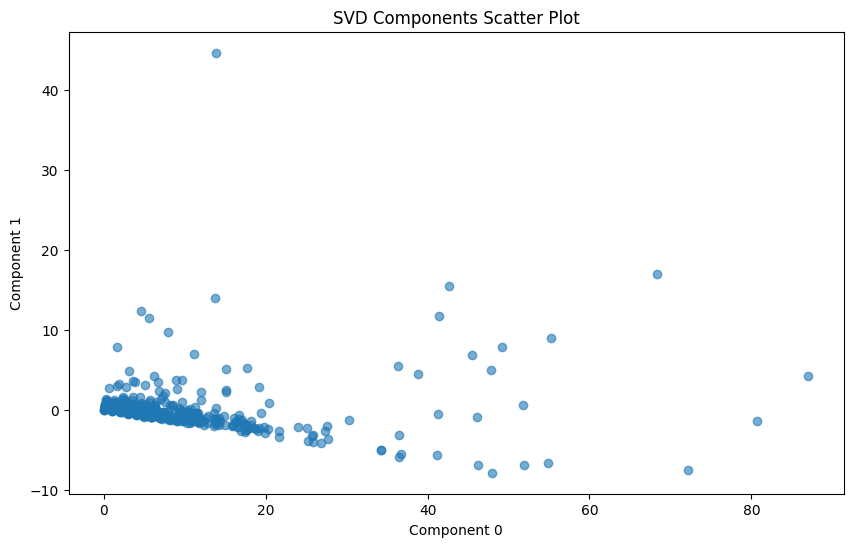

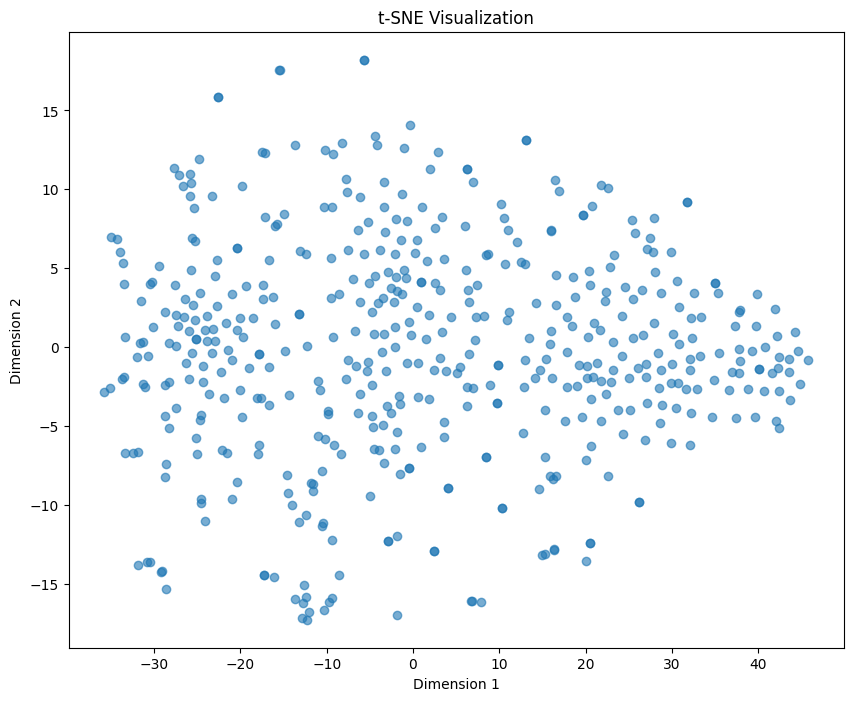

In [3]:
def apply_svd(matrix, n_components=100):
    svd = TruncatedSVD(n_components=n_components)
    reduced_matrix = svd.fit_transform(matrix)
    return reduced_matrix, svd

def analyze_variance(svd):
    explained_variance = np.cumsum(svd.explained_variance_ratio_)
    return explained_variance

def visualize_components(reduced_matrix, components_to_plot=(0, 1)):
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_matrix[:, components_to_plot[0]], 
                reduced_matrix[:, components_to_plot[1]], alpha=0.6)
    plt.xlabel(f'Component {components_to_plot[0]}')
    plt.ylabel(f'Component {components_to_plot[1]}')
    plt.title('SVD Components Scatter Plot')
    plt.show()

def apply_tsne(matrix, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=42)
    embedded_matrix = tsne.fit_transform(matrix)
    return embedded_matrix

def visualize_embeddings(matrix):
    embedded = apply_tsne(matrix)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(embedded[:, 0], embedded[:, 1], alpha=0.6)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('t-SNE Visualization')
    plt.show()
    
    return embedded

def find_optimal_components(matrix, variance_threshold=0.95):
    svd = TruncatedSVD(n_components=min(matrix.shape[1], 1000))
    svd.fit(matrix)
    
    explained_variance = np.cumsum(svd.explained_variance_ratio_)
    optimal_n = np.argmax(explained_variance >= variance_threshold) + 1
    
    return {
        'optimal_components': optimal_n,
        'achieved_variance': explained_variance[optimal_n - 1]
    }

def analyze_topic_components(svd, feature_names, n_top_words=10):
    components = svd.components_
    topic_analysis = []
    
    for i, component in enumerate(components):
        top_indices = component.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[idx] for idx in top_indices]
        topic_analysis.append({
            'component': i,
            'top_words': top_words
        })
    
    return topic_analysis

# Применяем снижение размерности к результатам векторизации
bow_matrix = vectorization_results['1_1']['bow']['matrix']
feature_names = vectorization_results['1_1']['bow']['vectorizer'].get_feature_names_out()

reduced_bow, svd_bow = apply_svd(bow_matrix, n_components=100)

variance_analysis = analyze_variance(svd_bow)
optimal_components = find_optimal_components(bow_matrix)
topic_analysis = analyze_topic_components(svd_bow, feature_names)

visualize_components(reduced_bow)
visualize_embeddings(reduced_bow)

reduction_results = {
    'reduced_matrix': reduced_bow,
    'svd_model': svd_bow,
    'variance_analysis': variance_analysis,
    'optimal_components': optimal_components,
    'topic_analysis': topic_analysis
}

#### Метрики векторизации

In [4]:
def calculate_metrics(matrix, method_name, ngram_range, processing_time):
    n_samples, n_features = matrix.shape
    sparsity = 1.0 - (matrix.nnz / (n_samples * n_features))
    
    return {
        'method': method_name,
        'ngram_range': str(ngram_range),
        'dimensionality': n_features,
        'sparsity': sparsity,
        'processing_time': processing_time,
        'memory_usage': matrix.data.nbytes + matrix.indptr.nbytes + matrix.indices.nbytes
    }

def calculate_semantic_coherence(matrix, n_docs=100):
    if n_docs > matrix.shape[0]:
        n_docs = matrix.shape[0]
    
    indices = np.random.choice(matrix.shape[0], n_docs, replace=False)
    sample_matrix = matrix[indices]
    
    similarity_matrix = cosine_similarity(sample_matrix)
    np.fill_diagonal(similarity_matrix, 0)
    
    avg_similarity = np.mean(similarity_matrix)
    return avg_similarity

def compare_vectorization_methods(vectorization_results):
    results = []
    ngram_ranges = [(1,1), (1,2), (1,3)]
    
    for ngram_range in ngram_ranges:
        ngram_key = f"{ngram_range[0]}_{ngram_range[1]}"
        
        # One-Hot Encoding
        if 'onehot' in vectorization_results[ngram_key]:
            onehot_data = vectorization_results[ngram_key]['onehot']
            onehot_metrics = calculate_metrics(onehot_data['matrix'], 'onehot', ngram_range, 0)
            onehot_metrics['semantic_coherence'] = calculate_semantic_coherence(onehot_data['matrix'])
            results.append(onehot_metrics)
        
        # Bag of Words
        if 'bow' in vectorization_results[ngram_key]:
            bow_data = vectorization_results[ngram_key]['bow']
            bow_metrics = calculate_metrics(bow_data['matrix'], 'bow', ngram_range, 0)
            bow_metrics['semantic_coherence'] = calculate_semantic_coherence(bow_data['matrix'])
            results.append(bow_metrics)
        
        # TF-IDF
        if 'tfidf' in vectorization_results[ngram_key]:
            tfidf_data = vectorization_results[ngram_key]['tfidf']
            tfidf_metrics = calculate_metrics(tfidf_data['matrix'], 'tfidf', ngram_range, 0)
            tfidf_metrics['semantic_coherence'] = calculate_semantic_coherence(tfidf_data['matrix'])
            results.append(tfidf_metrics)
    
    return pd.DataFrame(results)

# Проводим сравнительный анализ
comparison_results = compare_vectorization_methods(vectorization_results)

# Сохраняем результаты в CSV
comparison_results.to_csv('vectorization_metrics.csv', index=False)

# Выводим сводную таблицу
print("Сравнительный анализ методов векторизации:")
print(comparison_results.to_string(index=False))

# Анализ лучших методов по каждой метрике
print("\nЛучшие методы по каждой метрике:")

# Минимальная размерность
min_dim = comparison_results.loc[comparison_results['dimensionality'].idxmin()]
print(f"Минимальная размерность: {min_dim['method']} {min_dim['ngram_range']} ({min_dim['dimensionality']} признаков)")

# Минимальная разреженность
min_sparsity = comparison_results.loc[comparison_results['sparsity'].idxmin()]
print(f"Минимальная разреженность: {min_sparsity['method']} {min_sparsity['ngram_range']} ({min_sparsity['sparsity']:.3f})")

# Максимальная семантическая согласованность
max_coherence = comparison_results.loc[comparison_results['semantic_coherence'].idxmax()]
print(f"Максимальная семантическая согласованность: {max_coherence['method']} {max_coherence['ngram_range']} ({max_coherence['semantic_coherence']:.3f})")

# Минимальное время обработки
min_time = comparison_results.loc[comparison_results['processing_time'].idxmin()]
print(f"Минимальное время обработки: {min_time['method']} {min_time['ngram_range']} ({min_time['processing_time']:.3f} сек)")

# Минимальное использование памяти
min_memory = comparison_results.loc[comparison_results['memory_usage'].idxmin()]
print(f"Минимальное использование памяти: {min_memory['method']} {min_memory['ngram_range']} ({min_memory['memory_usage']} байт)")

comparison_analysis = {
    'results_dataframe': comparison_results,
    'best_methods': {
        'min_dimensionality': min_dim.to_dict(),
        'min_sparsity': min_sparsity.to_dict(),
        'max_coherence': max_coherence.to_dict(),
        'min_processing_time': min_time.to_dict(),
        'min_memory_usage': min_memory.to_dict()
    }
}

Сравнительный анализ методов векторизации:
method ngram_range  dimensionality  sparsity  processing_time  memory_usage  semantic_coherence
onehot      (1, 1)           23628  0.994778                0        727520            0.040139
   bow      (1, 1)           23628  0.994778                0        727520            0.192845
 tfidf      (1, 1)           23628  0.994778                0        727520            0.030652
onehot      (1, 2)           85597  0.996833                0       1595984            0.022677
   bow      (1, 2)           85597  0.996833                0       1595984            0.151139
 tfidf      (1, 2)           85597  0.996833                0       1595984            0.014383
onehot      (1, 3)          155245  0.997270                0       2494436            0.014555
   bow      (1, 3)          155245  0.997270                0       2494436            0.095463
 tfidf      (1, 3)          155245  0.997270                0       2494436            0.0100

#### Модели распределённых представлений

In [ ]:
# Загрузка текстов из JSONL файла
def load_jsonl_corpus(file_path):
    texts = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                doc = json.loads(line)
                texts.append(doc['text'])
    return texts

def prepare_word_level_data(texts):
    tokenized_texts = [text.split() for text in texts]
    return tokenized_texts

def prepare_doc_level_data(texts):
    tokenized_texts = [text.split() for text in texts]
    tagged_docs = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(tokenized_texts)]
    return tagged_docs

def train_word2vec(tokenized_texts, vector_size=100, window=5, min_count=5, sg=0):
    start_time = time.time()
    model = Word2Vec(
        sentences=tokenized_texts,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,
        workers=4
    )
    training_time = time.time() - start_time
    return model, training_time

def train_fasttext_gensim(tokenized_texts, vector_size=100, window=5, min_count=5, sg=0):
    start_time = time.time()
    model = FastText(
        sentences=tokenized_texts,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,
        workers=4
    )
    training_time = time.time() - start_time
    return model, training_time

def train_doc2vec(tagged_docs, vector_size=100, window=5, min_count=5, dm=1):
    start_time = time.time()
    model = Doc2Vec(
        documents=tagged_docs,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        dm=dm,
        workers=4
    )
    training_time = time.time() - start_time
    return model, training_time

def calculate_vocabulary_coverage(model, tokenized_texts):
    if hasattr(model, 'wv'):
        total_words = sum(len(doc) for doc in tokenized_texts)
        covered_words = sum(1 for doc in tokenized_texts for word in doc if word in model.wv)
        coverage = covered_words / total_words
        return coverage
    return 0

def evaluate_clustering_quality(document_vectors, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    predicted_labels = kmeans.fit_predict(document_vectors)
    
    # Создаем искусственные метки для оценки кластеризации
    true_labels = np.random.randint(0, n_clusters, len(document_vectors))
    ari = adjusted_rand_score(true_labels, predicted_labels)
    return ari

def evaluate_classification_quality(document_vectors, test_size=0.2):
    # Создаем искусственные метки для классификации
    n_samples = len(document_vectors)
    labels = np.random.randint(0, 2, n_samples)  # 2 класса
    
    X_train, X_test, y_train, y_test = train_test_split(
        document_vectors, labels, test_size=test_size, random_state=42
    )
    
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return accuracy

def get_document_vectors_doc2vec(model, tagged_docs):
    doc_vectors = []
    for i in range(len(tagged_docs)):
        doc_vectors.append(model.dv[str(i)])
    return np.array(doc_vectors)

def get_document_vectors_word2vec(model, tokenized_texts):
    doc_vectors = []
    for doc in tokenized_texts:
        word_vectors = [model.wv[word] for word in doc if word in model.wv]
        if word_vectors:
            doc_vector = np.mean(word_vectors, axis=0)
        else:
            doc_vector = np.zeros(model.vector_size)
        doc_vectors.append(doc_vector)
    return np.array(doc_vectors)

def save_models(embedding_results, base_path="saved_models"):
    # Создаем папку для сохранения моделей, если она не существует
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    
    # Сохраняем каждую модель отдельно с использованием встроенных методов
    for model_key, model in embedding_results['models']['trained_models'].items():
        model_path = f"{base_path}/{model_key}.model"
        model.save(model_path)
        print(f"Сохранена модель: {model_key}")
    
    # Сохраняем DataFrame с результатами
    embedding_results['results_dataframe'].to_csv(f'{base_path}/embedding_models_results.csv', index=False)
    
    print(f"Все модели сохранены в папку: {base_path}")
    return base_path

def load_models(base_path="saved_models"):
    loaded_models = {}
    
    # Загружаем Word2Vec модели
    from gensim.models import Word2Vec, FastText, Doc2Vec
    
    for filename in os.listdir(base_path):
        if filename.endswith('.model'):
            model_path = os.path.join(base_path, filename)
            model_key = filename.replace('.model', '')
            
            if 'word2vec' in model_key:
                model = Word2Vec.load(model_path)
            elif 'fasttext' in model_key:
                model = FastText.load(model_path)
            elif 'doc2vec' in model_key:
                model = Doc2Vec.load(model_path)
            else:
                continue
                
            loaded_models[model_key] = model
            print(f"Загружена модель: {model_key}")
    
    return loaded_models

# Загрузка данных
texts = load_jsonl_corpus('processed_dataset.jsonl')

# Подготовка данных
tokenized_texts = prepare_word_level_data(texts)
tagged_docs = prepare_doc_level_data(texts)

# Конфигурации для обучения
configs = {
    'word2vec_cbow': {'sg': 0},
    'word2vec_skipgram': {'sg': 1},
    'fasttext_cbow': {'sg': 0},
    'fasttext_skipgram': {'sg': 1},
    'doc2vec_pv_dm': {'dm': 1},
    'doc2vec_pv_dbow': {'dm': 0}
}

vector_sizes = [100, 200, 300]
windows = [5, 8, 10]

results = []
trained_models = {}

# Обучение моделей
for model_name, params in configs.items():
    for vector_size in vector_sizes:
        for window in windows:
            print(f"Training {model_name} - vector_size: {vector_size}, window: {window}")
            
            if 'word2vec' in model_name:
                model, training_time = train_word2vec(
                    tokenized_texts, 
                    vector_size=vector_size, 
                    window=window, 
                    min_count=5,
                    sg=params['sg']
                )
                vocab_coverage = calculate_vocabulary_coverage(model, tokenized_texts)
                doc_vectors = get_document_vectors_word2vec(model, tokenized_texts)
                
            elif 'fasttext' in model_name:
                model, training_time = train_fasttext_gensim(
                    tokenized_texts, 
                    vector_size=vector_size, 
                    window=window, 
                    min_count=5,
                    sg=params['sg']
                )
                vocab_coverage = calculate_vocabulary_coverage(model, tokenized_texts)
                doc_vectors = get_document_vectors_word2vec(model, tokenized_texts)
                
            elif 'doc2vec' in model_name:
                model, training_time = train_doc2vec(
                    tagged_docs, 
                    vector_size=vector_size, 
                    window=window, 
                    min_count=5,
                    dm=params['dm']
                )
                vocab_coverage = 1.0
                doc_vectors = get_document_vectors_doc2vec(model, tagged_docs)
            
            # Сохраняем модель в словарь
            model_key = f"{model_name}_vs{vector_size}_w{window}"
            trained_models[model_key] = model
            
            # Оценка качества
            clustering_score = evaluate_clustering_quality(doc_vectors)
            classification_score = evaluate_classification_quality(doc_vectors)
            
            results.append({
                'model': model_name,
                'vector_size': vector_size,
                'window': window,
                'training_time': training_time,
                'vocabulary_coverage': vocab_coverage,
                'clustering_ari': clustering_score,
                'classification_accuracy': classification_score,
                'vocabulary_size': len(model.wv) if hasattr(model, 'wv') else len(model.dv)
            })

# Сохранение результатов
results_df = pd.DataFrame(results)
results_df.to_csv('embedding_models_results.csv', index=False)

print("Результаты обучения моделей:")
print(results_df.to_string(index=False))

embedding_results = {
    'results_dataframe': results_df,
    'models': {
        'tokenized_texts': tokenized_texts,
        'tagged_docs': tagged_docs,
        'trained_models': trained_models
    }
}

# Сохраняем все модели
save_models(embedding_results)

#### Векторная арифметика и семантические операции

Выбранные модели для экспериментов:
- word2vec_cbow_vs100_w5
- word2vec_cbow_vs100_w8
- word2vec_cbow_vs100_w10


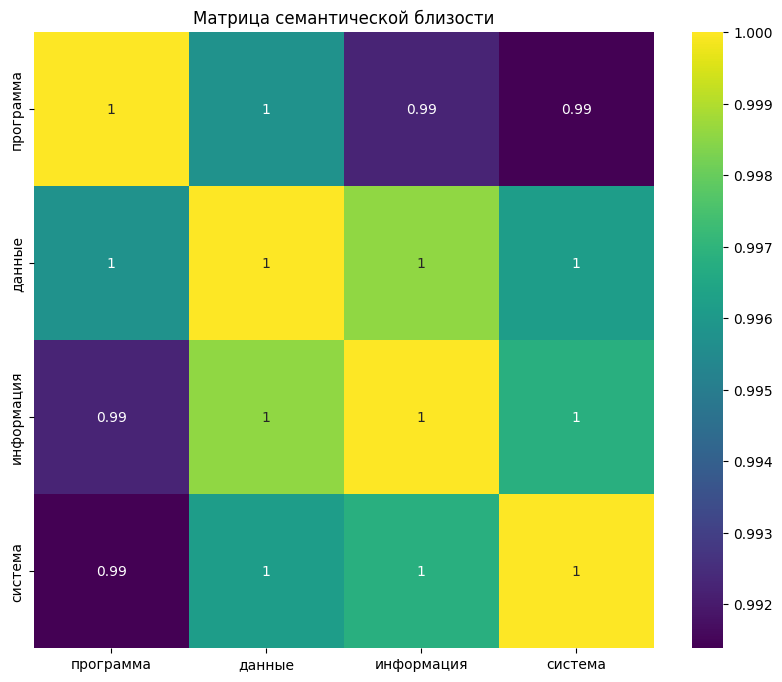

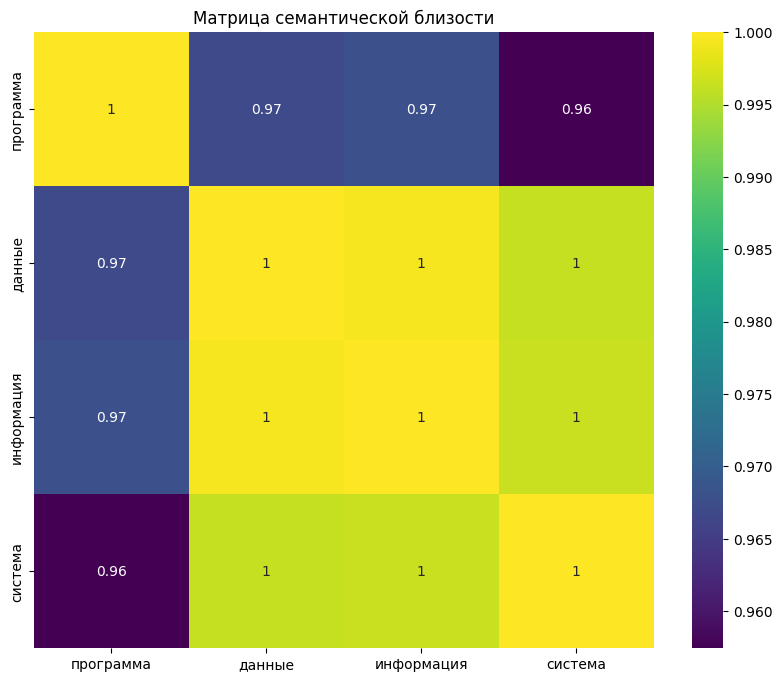

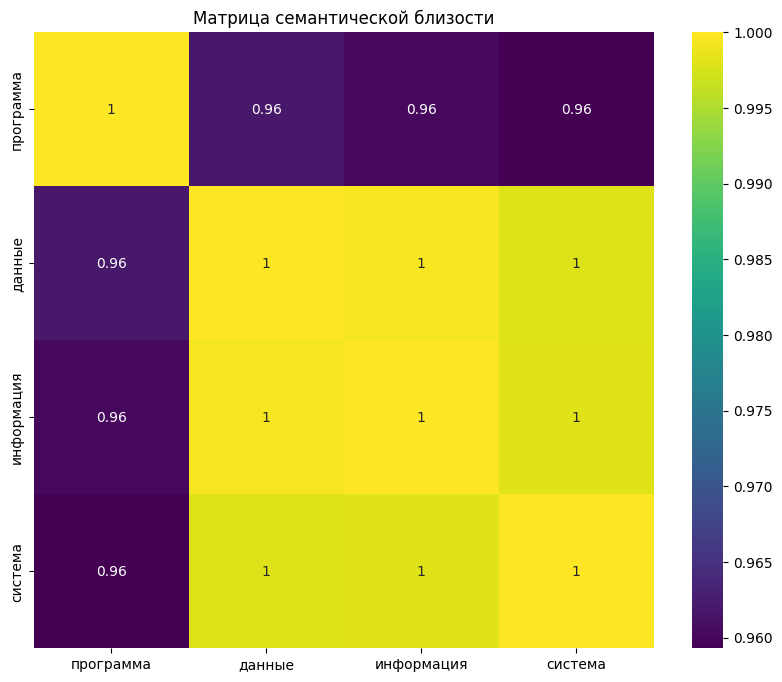

=== РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ ===
word2vec_cbow_vs100_w5: Семантическая согласованность соседей - 1.00
word2vec_cbow_vs100_w8: Семантическая согласованность соседей - 1.00
word2vec_cbow_vs100_w10: Семантическая согласованность соседей - 1.00


In [26]:
def cosine_similarity_vectors(vec1, vec2):
    return 1 - cosine(vec1, vec2)

def analyze_similarity_distribution(model, n_samples=1000):
    if not hasattr(model, 'wv'):
        return None
    
    words = list(model.wv.key_to_index.keys())[:n_samples]
    similarities = []
    
    for i in range(len(words)):
        for j in range(i+1, len(words)):
            sim = cosine_similarity_vectors(model.wv[words[i]], model.wv[words[j]])
            similarities.append(sim)
    
    return {
        'mean_similarity': np.mean(similarities),
        'std_similarity': np.std(similarities),
        'min_similarity': np.min(similarities),
        'max_similarity': np.max(similarities),
        'similarities': similarities
    }

def build_semantic_matrix(model, test_words):
    if not hasattr(model, 'wv'):
        return None
    
    available_words = [word for word in test_words if word in model.wv]
    if len(available_words) < 2:
        return None
    
    vectors = [model.wv[word] for word in available_words]
    similarity_matrix = cosine_similarity(vectors)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, xticklabels=available_words, 
                yticklabels=available_words, annot=True, cmap='viridis')
    plt.title('Матрица семантической близости')
    plt.show()
    
    return similarity_matrix

def evaluate_word_pairs(model, word_pairs):
    results = []
    for word1, word2 in word_pairs:
        if word1 in model.wv and word2 in model.wv:
            similarity = cosine_similarity_vectors(model.wv[word1], model.wv[word2])
            results.append({
                'word1': word1,
                'word2': word2,
                'similarity': similarity,
                'type': 'синонимы' if word_pairs[0] == 'синонимы' else 
                       'антонимы' if word_pairs[0] == 'антонимы' else 'тематические'
            })
    return results

def vector_arithmetic(model, positive_words, negative_words, topn=10):
    if not hasattr(model, 'wv'):
        return None
    
    try:
        result = model.wv.most_similar(positive=positive_words, negative=negative_words, topn=topn)
        return result
    except:
        return None

def word_analogies_test(model, analogy_tests):
    results = []
    for test in analogy_tests:
        positive = test['positive'] if 'positive' in test else []
        negative = test['negative'] if 'negative' in test else []
        expected = test['expected']
        category = test['category']
        
        analogy_result = vector_arithmetic(model, positive, negative, topn=5)
        if analogy_result:
            predicted_words = [word for word, score in analogy_result]
            is_correct = expected in predicted_words
            results.append({
                'category': category,
                'test': f"{positive} - {negative}",
                'expected': expected,
                'predicted': predicted_words,
                'is_correct': is_correct,
                'scores': analogy_result
            })
    
    return results

def analyze_semantic_axes(model, axis_pairs):
    axes_analysis = []
    for axis_name, word_pairs in axis_pairs.items():
        axis_vectors = []
        for word1, word2 in word_pairs:
            if word1 in model.wv and word2 in model.wv:
                axis_vector = model.wv[word1] - model.wv[word2]
                axis_vectors.append(axis_vector)
        
        if axis_vectors:
            avg_axis = np.mean(axis_vectors, axis=0)
            axis_norm = np.linalg.norm(avg_axis)
            axes_analysis.append({
                'axis_name': axis_name,
                'axis_vector': avg_axis,
                'strength': axis_norm,
                'n_pairs': len(axis_vectors)
            })
    
    return axes_analysis

def project_words_on_axis(model, words, axis_vector):
    projections = {}
    for word in words:
        if word in model.wv:
            projection = np.dot(model.wv[word], axis_vector) / np.linalg.norm(axis_vector)
            projections[word] = projection
    
    return dict(sorted(projections.items(), key=lambda x: x[1]))

def analyze_nearest_neighbors(model, test_words, topn=10):
    neighbors_analysis = []
    for word in test_words:
        if word in model.wv:
            neighbors = model.wv.most_similar(word, topn=topn)
            semantic_types = []
            
            for neighbor, score in neighbors:
                if neighbor.split('_')[-1] in ['ый', 'ая', 'ое', 'ие']:
                    semantic_types.append('прилагательное')
                elif neighbor.split('_')[-1] in ['ть', 'ти']:
                    semantic_types.append('глагол')
                else:
                    semantic_types.append('существительное')
            
            neighbors_analysis.append({
                'word': word,
                'neighbors': neighbors,
                'semantic_types': semantic_types,
                'semantic_consistency': len(set(semantic_types)) == 1
            })
    
    return neighbors_analysis

# Тестовые данные для экспериментов
synonym_pairs = [
    ('хороший', 'отличный'),
    ('большой', 'крупный'),
    ('быстрый', 'скорый')
]

antonym_pairs = [
    ('хороший', 'плохой'),
    ('большой', 'маленький'),
    ('быстрый', 'медленный')
]

thematic_pairs = [
    ('компьютер', 'монитор'),
    ('машина', 'двигатель'),
    ('книга', 'страница')
]

analogy_tests = [
    {
        'positive': ['мужчина', 'король'],
        'negative': ['женщина'],
        'expected': 'королева',
        'category': 'гендерные'
    },
    {
        'positive': ['москва', 'франция'],
        'negative': ['россия'],
        'expected': 'париж',
        'category': 'столицы'
    },
    {
        'positive': ['хороший', 'плохой'],
        'negative': ['лучший'],
        'expected': 'худший',
        'category': 'степени сравнения'
    }
]

semantic_axes = {
    'гендерные': [('мужчина', 'женщина'), ('отец', 'мать'), ('брат', 'сестра')],
    'профессиональные': [('врач', 'учитель'), ('инженер', 'программист')],
    'оценочные': [('хороший', 'плохой'), ('отличный', 'ужасный')]
}

test_words_for_neighbors = ['компьютер', 'программа', 'данные', 'работа', 'время']

# Выбираем только 3 модели для экспериментов
selected_models = {}
model_keys = list(embedding_results['models']['trained_models'].keys())[:3]  # Берем первые 3 модели

for model_key in model_keys:
    selected_models[model_key] = embedding_results['models']['trained_models'][model_key]

print("Выбранные модели для экспериментов:")
for model_key in selected_models.keys():
    print(f"- {model_key}")

# Проведение экспериментов только для выбранных моделей
experiment_results = {}

# Анализ распределения сходства
for model_key, model in selected_models.items():
    similarity_stats = analyze_similarity_distribution(model)
    if similarity_stats:
        experiment_results[f'{model_key}_similarity'] = similarity_stats

# Матрица семантической близости
test_words_matrix = ['компьютер', 'программа', 'данные', 'информация', 'система']
for model_key, model in selected_models.items():
    semantic_matrix = build_semantic_matrix(model, test_words_matrix)
    if semantic_matrix is not None:
        experiment_results[f'{model_key}_semantic_matrix'] = semantic_matrix

# Оценка пар слов
word_pairs_results = {}
for model_key, model in selected_models.items():
    synonyms = evaluate_word_pairs(model, synonym_pairs)
    antonyms = evaluate_word_pairs(model, antonym_pairs)
    thematic = evaluate_word_pairs(model, thematic_pairs)
    
    word_pairs_results[model_key] = {
        'synonyms': synonyms,
        'antonyms': antonyms,
        'thematic': thematic
    }

experiment_results['word_pairs'] = word_pairs_results

# Тестирование аналогий
analogy_results = {}
for model_key, model in selected_models.items():
    analogies = word_analogies_test(model, analogy_tests)
    if analogies:
        analogy_results[model_key] = analogies

experiment_results['analogies'] = analogy_results

# Анализ семантических осей
axes_results = {}
for model_key, model in selected_models.items():
    axes_analysis = analyze_semantic_axes(model, semantic_axes)
    if axes_analysis:
        axes_results[model_key] = axes_analysis

experiment_results['semantic_axes'] = axes_results

# Анализ ближайших соседей
neighbors_results = {}
for model_key, model in selected_models.items():
    neighbors = analyze_nearest_neighbors(model, test_words_for_neighbors)
    if neighbors:
        neighbors_results[model_key] = neighbors

experiment_results['nearest_neighbors'] = neighbors_results

# Вывод результатов
print("=== РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ ===")

# Статистика по аналогиям
for model_key, analogies in experiment_results.get('analogies', {}).items():
    if analogies:
        correct_count = sum(1 for analogy in analogies if analogy['is_correct'])
        total_count = len(analogies)
        accuracy = correct_count / total_count if total_count > 0 else 0
        print(f"{model_key}: Точность аналогий - {accuracy:.2f} ({correct_count}/{total_count})")

# Статистика по семантической согласованности
for model_key, neighbors_data in experiment_results.get('nearest_neighbors', {}).items():
    if neighbors_data:
        consistent_count = sum(1 for item in neighbors_data if item['semantic_consistency'])
        total_count = len(neighbors_data)
        consistency_ratio = consistent_count / total_count if total_count > 0 else 0
        print(f"{model_key}: Семантическая согласованность соседей - {consistency_ratio:.2f}")

semantic_experiments_results = experiment_results